In [28]:
import sys
import unittest

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("whitegrid", {'axes.grid' : False})

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import torchsummary
from collections import deque

%matplotlib inline

# Tensors

A tensor is an n-dimensional array consisting of elements of the same type. Every tensor has an associated shape that describes the dimensions of the tensor. For example, the shape of a 4D tensor would have four numbers that specify the size of each of the four dimensions.

- **vector:** 1D tensor with shape `[N]` where N denotes the number of elements
- **matrix:** 2D tensor with shape `[R, C]` where R and C denote the number of rows and columns, respectively
- **RGB image:** 3D tensor with shape `[C, H, W]` where C denotes the number of channels (representing color) and H and W denote the height and width, respectively

The number of tensor dimensions is known as "the rank of the tensor". Each tensor dimension is known as "an axis" of the tensor. An axis with a dimension of one is known as a singleton axis. Example usage: "In a rank four tensor of shape `[N, C, H, W]`, N denotes the dimension/size of the leading axis."

A tensor containing a batch of images would typically have the following shape: [N, C, H, W]. `N` indicates the number of images in the batch, `C` indicates the number of channels (one for grayscale images and typically three for color images), H and W are the height and width of the image respectively. Note that the dimensions of each image is fixed; we cannot store images of different sizes in the same tensor.

# Convolution Arithmetic

The convolution operation takes two tensors as input and results in one tensor as output (sometimes, we add a "bias" tensor to the result after convolving). The shape of the output tensor depends on the shape of the input tensor, weights/filters tensor, and convolution configuration such as padding.

The convolution layer in a neural network generally convolves the same input with many filters (ranging from few dozen to hundreds to thousands). It is equivalent to convolving the image with each filter separately and then concatenating the results into a single tensor. We also often convolve the same set of filters on a collection of input tensors (like in minibatch gradient descent).

Using the visualizations below as an aid, write a function that outputs the shape of the output tensor for a given input shape, filters shape, and convolution configuration.

<table>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/same_padding_no_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/full_padding_no_strides.gif"></td>
  </tr>
  <tr>
    <td>No padding, no strides</td>
    <td>Padding of one, no strides</td>
    <td>Padding of two, no strides</td>
  </tr>
  <tr>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides.gif"></td>
    <td><img width="150px" src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/padding_strides_odd.gif"></td>
  </tr>
  <tr>
    <td>No padding, stride of two</td>
    <td>Padding of one, stide of two</td>
    <td>Padding of one, stride of two</td>
  </tr>
</table>

**References:**
"A guide to convolution arithmetic for deep learning", https://arxiv.org/abs/1603

License for images: https://github.com/vdumoulin/conv_arithmetic/blob/master/LICENSE


In [29]:
def getConvolutionOutputShape(B, C, H, W, K, M, N, Ph=0, Pw=0, Sh=1, Sw=1):
  """
    Computes the output shape of 2D convolution for a given input and filters shape

    Input shape: [B, C, H, W]
    Filters shape: [K, C, H, W]
    
    Padding and strides are relevant for spatial dimensions only (height and width).

  Args:
    B: batch size
    C: number of input channels
    H: height of the input
    W: width of the input
    K: number of filters
    M: height of the filters
    N: width of the filters
    Ph: vertical padding
    Pw: horizontal padding
    Sh: vertical stride
    Sw: horizontal stride
  """

  output_shape = np.zeros(4, dtype=int)

  # the calculation is independent and identical for each spatial axis
  def calculate_output_dim(input_size, filter_size, padding, stride):
    """returns the output dimension for a spatial axis"""
    # YOUR CODE BEGINS HERE
    return B, K, (2*Ph+H-M)//Sh+1, (2*Pw+W-N)//Sw+1
    # YOUR CODE ENDS HERE


  # YOUR CODE BEGINS HERE
  o0, o1, o2, o3 = calculate_output_dim(H,M,Ph,Sh)
  output_shape[0] = o0
  output_shape[1] = o1
  output_shape[2] = o2
  output_shape[3] = o3
  # YOUR CODE ENDS HERE

  return list(output_shape)

In [30]:
class Test_getConvolutionOutputShape(unittest.TestCase):
  def test_simple(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 32, 16, 3, 3), [1, 16, 26, 30])
    self.assertEqual(getConvolutionOutputShape(5, 3, 32, 28, 32, 3, 3), [5, 32, 30, 26])
    self.assertEqual(getConvolutionOutputShape(7, 256, 28, 28, 64, 3, 1), [7, 64, 26, 28])
    self.assertEqual(getConvolutionOutputShape(11, 256, 28, 28, 128, 1, 3), [11, 128, 28, 26])
    self.assertEqual(getConvolutionOutputShape(13, 1, 64, 64, 16, 5, 5), [13, 16, 60, 60])

  def test_padding(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 32, 28, 16, 3, 3, 1, 1), [1, 16, 32, 28])
    self.assertEqual(getConvolutionOutputShape(1, 16, 28, 32, 32, 3, 3, 3, 3), [1, 32, 32, 36])
    self.assertEqual(getConvolutionOutputShape(1, 33, 28, 28, 64, 3, 1, 1, 0), [1, 64, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 128, 1, 3, 0, 1), [1, 128, 28, 28])
    self.assertEqual(getConvolutionOutputShape(1, 4, 7, 11, 16, 5, 5, 2, 2), [1, 16, 7, 11])

  def test_strides(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 28, 28, 16, 3, 3, 0, 0, 2, 2), [1, 16, 13, 13])
    self.assertEqual(getConvolutionOutputShape(1, 32, 28, 28, 32, 3, 3, 1, 1, 2, 2), [1, 32, 14, 14])
    self.assertEqual(getConvolutionOutputShape(1, 64, 28, 28, 64, 3, 1, 2, 2, 2, 2), [1, 64, 15, 16])
    self.assertEqual(getConvolutionOutputShape(1, 128, 28, 28, 128, 1, 3, 0, 1, 4, 4), [1, 128, 7, 7])

  def test_misc(self):
    self.assertEqual(getConvolutionOutputShape(1, 1, 13, 13, 16, 1, 1), [1, 16, 13, 13])

unittest.main(Test_getConvolutionOutputShape(), argv=[''], verbosity=2, exit=False)

test_misc (__main__.Test_getConvolutionOutputShape) ... ok
test_padding (__main__.Test_getConvolutionOutputShape) ... ok
test_simple (__main__.Test_getConvolutionOutputShape) ... ok
test_strides (__main__.Test_getConvolutionOutputShape) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.012s

OK


# Convolution

Implement the `convolve2d` that convolves a filter (unit strides and zero padding) on a greyscale image. The animated visual aid shows this configuration.

<img src="https://raw.githubusercontent.com/vdumoulin/conv_arithmetic/master/gif/no_padding_no_strides.gif"/>

In [31]:
def convolve2d(image, kernel):
  """
    Convolve a 2D image with a kernel (2D filter)

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = H-M+1
  result_W = W-N+1
  # YOUR CODE ENDS HERE

  result = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE
  # Implement convolution using two loops
  for i in range(result_H):
      for j in range(result_W):
          result[i][j] = np.sum(np.multiply(image[i: i + M,j: j + N], kernel))
  # YOUR CODE ENDS HERE

  return result

In [32]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((256, 256))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.619s

OK


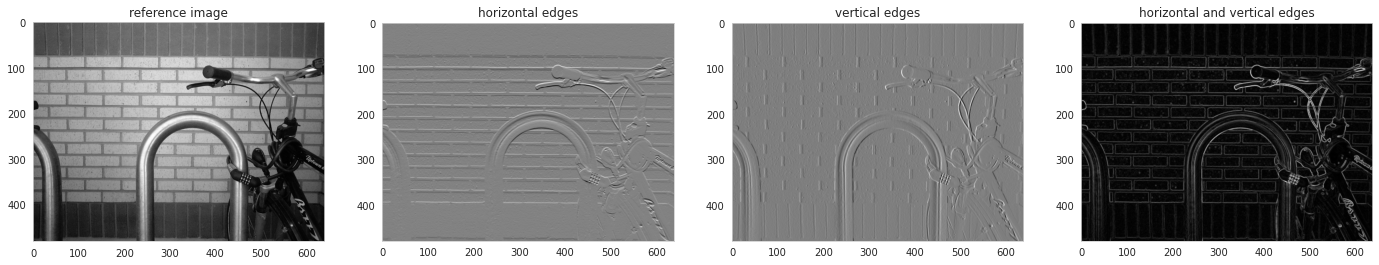

In [33]:
import skimage.io as sio
image = sio.imread("https://upload.wikimedia.org/wikipedia/commons/3/3f/Bikesgray.jpg", as_gray=True)

# https://en.wikipedia.org/wiki/Sobel_operator
sobel_filter_horizontal = np.asarray([
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]
], dtype=np.float32)

sobel_filter_vertical = sobel_filter_horizontal.T

# convolve image with Sobel operators using your implementation
image_sobel_h = convolve2d(image, sobel_filter_horizontal)
image_sobel_v = convolve2d(image, sobel_filter_vertical)
image_sobel_hv =  np.sqrt(image_sobel_h**2 + image_sobel_v**2)

# convolve image with Sobel operators using reference implementation
image_sobel_h_ref = convolve2d_ref(image, sobel_filter_horizontal)
image_sobel_v_ref = convolve2d_ref(image, sobel_filter_vertical)

fig, axes = plt.subplots(1, 4, figsize=(24,6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("reference image")
axes[1].imshow(image_sobel_h, cmap='gray')
axes[1].set_title("horizontal edges")
axes[2].imshow(image_sobel_v, cmap='gray')
axes[2].set_title("vertical edges")
axes[3].imshow(image_sobel_hv, cmap='gray')
axes[3].set_title("horizontal and vertical edges")
plt.show()

# Convolution as Matrix Multiplication

Convolution is a linear operation. We can represent convolution as a matrix multiplication of a transformed filter matrix with the input matrix.

Consider an input $\mathbf{X}$ and a kernel $\mathbf{W}$.

$$$$

$$\mathbf{X} = \begin{pmatrix}x_{00} & x_{01} & x_{02} & x_{10} \\ x_{11} & x_{12} \\ x_{20} & x_{21} & x_{22} \end{pmatrix}\$$

$$\mathbf{W} = \begin{pmatrix}w_{00} & w_{01} \\ w_{10} & w_{11} \end{pmatrix}$$

$$$$

Let the result of the convolution of $\mathbf{X}$ with $\mathbf{W}$ be denoted by $\mathbf{Y}$.

$$\mathbf{Y} = \mathbf{X} * \mathbf{Y}$$

$$\mathbf{Y} = \begin{pmatrix}
w_{00}*x_{00} + w_{01}*x_{01} + w_{10}*x_{10} + w_{11}*x_{11} &
w_{00}*x_{01} + w_{01}*x_{02} + w_{10}*x_{11} + w_{11}*x_{12} \\
w_{00}*x_{10} + w_{01}*x_{11} + w_{10}*x_{20} + w_{11}*x_{21} &
w_{00}*x_{11} + w_{01}*x_{12} + w_{10}*x_{21} + w_{11}*x_{22}
 \end{pmatrix}$$

$$$$

We can express the result as matrix multiplication of a transformed weight matrix with the input matrix.

$$\mathbf{Y} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

1. Assuming the input and kernel shape to be `[H, W]` and `[M, N]` respectively, what is the shape of the transformed kernel matrix?
2. Complete the `transform_kernel` function. It must construct the transformed kernel matrix for a given input shape and kernel matrix.
3. Complete the `convolve2d_matmul` function. It must convolve the input with the given kernel using the transformed matrix.

**References:**
- https://github.com/alisaaalehi/convolution_as_multiplication

## Answers

1. Write your answer here

result_H = (H - M + 1) * (W - N + 1) -> height of the transformed kernel matrix
  result_W =  H * W -> width of the transformed kernel matrix

In [34]:
def transform_kernel(image, kernel):
  """
    Transform kernel matrix into a new matrix such that matrix multiplication of
    the transformed matrix with the flattened input gives the result of convolution.

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)

  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = (H - M + 1) * (W - N + 1)# height of the transformed kernel matrix
  result_W =  H * W # width of the transformed kernel matrix
  # YOUR CODE ENDS HERE

  transformed_kernel = np.zeros((result_H, result_W), dtype=np.float32)
  # YOUR CODE BEGINS HERE

  start = 0
  for row in range(result_H):
    itr = start
    for col in range(start):
      transformed_kernel[row][col] = 0
    for rw in range(M):
      for cl in range(N):
        transformed_kernel[row][itr] = kernel[rw][cl]
        itr += 1
      if rw!=M-1:
        for _ in range(W-N):
          transformed_kernel[row][itr] = 0
          itr += 1
    for col in range(itr, result_W):
      transformed_kernel[row][col] = 0
    if row % (W-N+1) == (W-N):
      start += N
    else:
      start += 1

  # YOUR CODE ENDS HERE

  return transformed_kernel

def convolve2d_matmul(image, kernel):
  """
    Convolve a 2D image with a 2D kernel

  Args:
    image: matrix of shape H x W
    kernel: matrix of shape M x N
  """

  image = np.asarray(image)
  kernel = np.asarray(kernel)
  
  H, W = image.shape
  M, N = kernel.shape

  # YOUR CODE BEGINS HERE
  result_H = H - M + 1
  result_W = W - N + 1
  # YOUR CODE ENDS HERE

  # YOUR CODE BEGINS HERE
  # 1. compute transformed kernel
  transformed_kernel = transform_kernel(image, kernel)
  # print(transformed_kernel)

  # 2. flatten input (reshape the 2D input to a 1D column vector)
  flat_image = np.array(np.concatenate(image).flat)
  # print(flat_image)

  # 3. matrix multiplication
  result = np.dot(transformed_kernel, flat_image)
  # print(result)

  # 4. reshape result (reshape back to 2D output from a 1D column vector)
  result = np.reshape(result, (result_H, result_W))
  # print(result)

  # YOUR CODE ENDS HERE

  return result

# convolve2d_matmul([[1,2,3], [4,5,6], [7,8,9]], [[1,2],[3,4]])

In [35]:
def convolve2d_ref(image, kernel):
  from scipy import signal
  return signal.correlate2d(image, kernel, mode='valid')

class test_convolve2d_matmul(unittest.TestCase):
  def test(self):
    image1 = np.random.random((16, 16))
    kernel1 = np.ones((3, 3), dtype=np.float32)
    kernel1 /= np.sum(kernel1)
    self.assertTrue(np.allclose(convolve2d_matmul(image1, kernel1), convolve2d_ref(image1, kernel1), rtol=1e-05, atol=1e-08))

    image2 = np.random.random((32, 32))
    kernel2 = np.asarray([[1, 2, 3], [4, 5, 6], [6, 7, 8]], dtype=np.float32)
    kernel2 /= np.sum(kernel2)
    self.assertTrue(np.allclose(convolve2d_matmul(image2, kernel2), convolve2d_ref(image2, kernel2), rtol=1e-05, atol=1e-08))

    image3 = np.random.random((64, 64))
    kernel3 = np.asarray([[0, 1, 0], [1, -4, 1], [0, 1, 0]], dtype=np.float32)
    kernel3 /= np.sum(np.abs(kernel3))
    self.assertTrue(np.allclose(convolve2d_matmul(image3, kernel3), convolve2d_ref(image3, kernel3), rtol=1e-05, atol=1e-08))

unittest.main(test_convolve2d_matmul(), argv=[''], verbosity=2, exit=False)

test (__main__.test_convolve2d_matmul) ... ok

----------------------------------------------------------------------
Ran 1 test in 5.812s

OK


## Comparing convolutional layer with fully-connected layer

$$\mathbf{Y}_{fc} = \begin{pmatrix}
w_{00} & w_{01} & w_{02} & w_{03} & w_{04} & w_{05} & w_{06} & w_{07} & w_{08} & w_{09} \\
w_{10} & w_{11} & w_{12} & w_{13} & w_{14} & w_{15} & w_{16} & w_{17} & w_{18} & w_{19} \\
w_{20} & w_{21} & w_{22} & w_{23} & w_{24} & w_{25} & w_{26} & w_{27} & w_{28} & w_{29} \\
w_{30} & w_{31} & w_{32} & w_{33} & w_{34} & w_{35} & w_{36} & w_{37} & w_{38} & w_{39}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

$$\mathbf{Y}_{conv} = \begin{pmatrix}
w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0 & 0 & 0 \\
0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 & 0  & 0\\
0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11} & 0 \\
0 & 0 & 0 & 0 & w_{00} & w_{01} & 0 & w_{10} & w_{11}
\end{pmatrix}
\space
\begin{pmatrix}
x_{00} \\
x_{01} \\
x_{02} \\
x_{10} \\
x_{11} \\
x_{12} \\
x_{20} \\
x_{21} \\
x_{22}
\end{pmatrix}$$

## Questions

1. Express the number of learnable parameters in a fully-connected layer (without bias) in terms of `B`, `K`, `C`, `H`, `W`, `M` and `N` (as defined earlier).
2. Express the number of learnable parameters in a convolutional layer (without bias) in terms of the number of inputs `N` and outputs `M`.
4. Imagine weight matrices of a convolutional and fully-connected layer such that both operations result in the same output shape for a given input shape (the transformed toeplitz matrix must have the same shape of the fully-connected layer weights). Run the next code cell. What patterns do you observe in the weights? Is the weights matrix dense or sparse?
4. Explain what you understand by the terms "sparse connectivity" and "weight sharing" in the context of convolutional layers.
5. If a fully-connected layer can mimic convolution and is more powerful in terms of the set of functions it can represent, what is the point of using convolutions instead of them?


## Answers

1. The number of learnable parameters in a fully connected layer (without bias) is $M * N$ as for every connection between $i^{th}$ input neuron and $j^{th}$ output neuron, we have a weight $w_{ij}$ as a learnable parameter.

2. The number of learnable parameters in a convolutional layer is $M * N * K * C$ (without bias) because the weights are now calculated for each kernel element, for each input channel and that for each filter.

3. We see that the weight matrix from the transformed kernel is sparse in nature while the weight matrix for fully connected layer is dense.

4. The sparse connectivity property means that each neuron is connected to only a limited number of other neurons and not all. It is generally done by making the kernel dimensions smaller than the input dimensions. 

  Weight sharing is the use of same weights in multiple CNN transformations. In CNNs, each filter is replicated across the entire visual field. These replicated units share the same parameterization (weight vector and bias) and form a feature map. The same parameters are also updated again and again during backpropagation. This means that all the neurons in a given convolutional layer respond to the same feature within their specific response field. The model, hence, improves as parameters corresponding to the same features are learnt in different scenarios.

5. Convolutional neural networks can be used for high dimensional data like images while fully-connected layers become inefficient in such cases. Convolutions also capture inherent properties of images by retaining the spatial and dimensional features of a particular image. By using convolution, some important features can be focussed on as not all input nodes affect each output node unlike what is assumed in fully connected network.

In [36]:
with np.printoptions(threshold=sys.maxsize, linewidth=128):
  print("A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)")
  print(np.arange(9 * 25, dtype=np.float32).reshape(9, 25))
  print()

  print("Transformed matrix for 3x3 kernel that operates on an input with shape 5x5")
  print(transform_kernel(np.zeros((5, 5)), [[1, 2, 3], [4, 5, 6], [7, 8, 9]]))
  print()

A weight matrix of fully-connected that takes an input of 5x5 (flattened to 25) and results in an output with shape 3x3 (flattened to 9)
[[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.]
 [ 25.  26.  27.  28.  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.  44.  45.  46.  47.  48.  49.]
 [ 50.  51.  52.  53.  54.  55.  56.  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.  72.  73.  74.]
 [ 75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.]
 [100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124.]
 [125. 126. 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140. 141. 142. 143. 144. 145. 146. 147. 148. 149.]
 [150. 151. 152. 153. 154. 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168

# Training Convolutional Neural Networks

You have to train an image classifier for CIFAR10 dataset. There are ten classes/labels in the dataset. Each image has the shape 3x32x32 (32 pixels wide and tall, with 3 color channels).The dataset consists of 50,000 training samples and 10,000 test samples.

In [37]:
# On Google Colab: Go to "Runtime" > "Change runtime type" > Select "GPU"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device:", device)

device: cuda


In [38]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# train_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=True, transform=transform)
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# test_dataset = torchvision.datasets.CIFAR10(root='./data', download=True, train=False, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=False, transform=transform)
print("training dataset size:", len(train_dataset))
print("test dataset size:", len(test_dataset))

Files already downloaded and verified
training dataset size: 50000
test dataset size: 10000


In [39]:
# YOUR CODE BEGINS HERE
# portion a part of the training dataset for validation
# use 90% of the training dataset for training and the rest for validation
# use `torch.utils.data.random_split`

train_size=int(len(train_dataset)*0.9)
valid_size=len(train_dataset)-train_size
train_dataset, valid_dataset=torch.utils.data.random_split(train_dataset,[train_size,valid_size])

# YOUR CODE ENDS HERE

print("training dataset size:", train_size)
print("validation dataset size:", valid_size)

training dataset size: 45000
validation dataset size: 5000


In [40]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset)
test_dataloader = torch.utils.data.DataLoader(test_dataset)

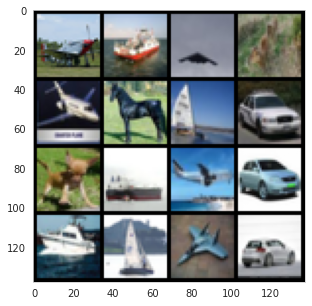

In [41]:
images, _ = next(iter(train_dataloader))
images = images * 0.5 + 0.5 # undo normalization for displaying images
plt.figure(figsize=(5,5))
plt.imshow(torchvision.utils.make_grid(images, nrow=4).permute(1, 2, 0))

In [42]:
class SMAIConvNet(nn.Module):
  def __init__(self):
    super(SMAIConvNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding='same')
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)

    # YOUR CODE BEGINS HERE
    # MaxPool2D with with window size 2x2
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding='same')
    self.maxpool2 =nn.MaxPool2d(kernel_size=2)

    # Conv2D with 32 filters, 3x3 kernel and 'same' padding
    self.conv3 =nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding='same')

    # Linear layer with 128 output features
    # Dropout with drop probability of 0.2
    self.fc1 = nn.Linear(in_features=16*8*8, out_features=128)
    self.dropout1 =nn.Dropout(p=0.2)

    # Linear layer with 10 output features
    self.fc2 = nn.Linear(in_features=128, out_features=10)
    # YOUR CODE ENDS HERE

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool1(x)
    x = F.relu(x)

    # YOUR CODE BEGINS HERE
    # conv2 > maxpool2 > ReLU
    x = self.conv2(x)
    x = self.maxpool2(x)
    x = F.relu(x)

    # conv3 > ReLU
    x = self.conv3(x)
    x = F.relu(x)
    x = x.view(-1, 16 * 8 * 8)

    # fc1 > dropout1 > ReLU
    x = self.fc1(x)
    x = self.dropout1(x)
    x = F.relu(x)

    # fc2
    x = self.fc2(x)

    # YOUR CODE ENDS HERE
    return x

In [43]:
torchsummary.summary(SMAIConvNet().to(device), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
         MaxPool2d-2            [-1, 8, 16, 16]               0
            Conv2d-3           [-1, 16, 16, 16]           1,168
         MaxPool2d-4             [-1, 16, 8, 8]               0
            Conv2d-5             [-1, 16, 8, 8]           2,320
            Linear-6                  [-1, 128]         131,200
           Dropout-7                  [-1, 128]               0
            Linear-8                   [-1, 10]           1,290
Total params: 136,202
Trainable params: 136,202
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 0.13
Params size (MB): 0.52
Estimated Total Size (MB): 0.66
----------------------------------------------------------------


In [44]:
def train(model, device, train_dataloader, optimizer, criterion):
  """trains for one epoch"""
  
  model.train()
  accumulated_loss = 0.0
  for data in train_dataloader:
    (inputs, labels) = data
    inputs = inputs.to(device)
    labels = labels.to(device)

    # YOUR CODE BEGINS HERE
    # 1. zero existing gradients
    optimizer.zero_grad()
    # 2. forward the inputs
    outputs = model(inputs)
    # 3. compute the loss
    loss = criterion(outputs, labels)
    # 4. backprop the loss
    loss.backward()
    # 5. update the weights
    optimizer.step()


    # YOUR CODE ENDS HERE

    accumulated_loss += loss.item()
  return accumulated_loss / len(train_dataloader)

def test(model, device, dataloader, criterion):
  model.eval()
  accumulated_loss = 0.0
  correct = 0
  with torch.no_grad():
    for data in dataloader:
      (inputs, labels) = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      # YOUR CODE BEGINS HERE
      # 1. forward the inputs
      outputs = model(inputs)
      # 2. compute the loss
      loss = criterion(outputs, labels)
      # YOUR CODE ENDS HERE

      accumulated_loss += loss.item()

      predictions = outputs.argmax(dim=1)
      correct += (predictions == labels).sum()

    num_samples = len(dataloader)
    avg_loss = accumulated_loss / num_samples
    return avg_loss, correct / num_samples
    

In [45]:
model = SMAIConvNet().to(device) # resets parameters

# YOUR CODE BEGINS HERE
# use CrossEntropyLoss
# use SGD with a lr=0.001 and momentum=0.9

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# YOUR CODE ENDS HERE

best_val_loss = np.Inf
loss_history = { "train" : [], "validation" : []}
for epoch in range(30):
  train_loss = train(model, device, train_dataloader, optimizer, criterion)  
  loss_history["train"].append(train_loss)

  val_loss, val_acc = test(model, device, valid_dataloader, criterion)
  loss_history["validation"].append(val_loss)

  if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
    print("new best model")
    torch.save(model.state_dict(), "best_model.pth")
    best_val_loss = val_loss

  print("[%d] training loss: %.2f" % (epoch + 1,train_loss))
  print("[%d] validation loss: %.2f, validation accuracy: %.2f%%" % (epoch + 1, val_loss, val_acc * 100))
  print()

new best model
[1] training loss: 2.06
[1] validation loss: 1.70, validation accuracy: 38.64%

new best model
[2] training loss: 1.60
[2] validation loss: 1.44, validation accuracy: 46.96%

new best model
[3] training loss: 1.44
[3] validation loss: 1.33, validation accuracy: 51.28%

new best model
[4] training loss: 1.33
[4] validation loss: 1.25, validation accuracy: 55.02%

new best model
[5] training loss: 1.24
[5] validation loss: 1.18, validation accuracy: 57.08%

new best model
[6] training loss: 1.17
[6] validation loss: 1.14, validation accuracy: 59.24%

new best model
[7] training loss: 1.10
[7] validation loss: 1.14, validation accuracy: 59.86%

new best model
[8] training loss: 1.05
[8] validation loss: 1.06, validation accuracy: 61.58%

new best model
[9] training loss: 1.01
[9] validation loss: 1.03, validation accuracy: 63.38%

new best model
[10] training loss: 0.96
[10] validation loss: 0.99, validation accuracy: 64.92%

new best model
[11] training loss: 0.92
[11] val

In [46]:
model.load_state_dict(torch.load("best_model.pth"))

test_loss, test_acc = test(model, device, test_dataloader, criterion)
print("test loss: %.2f, test accuracy: %.2f%%" % (test_loss, test_acc * 100))

test loss: 0.94, test accuracy: 67.31%


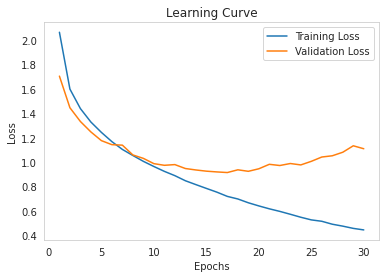

In [47]:
# plot the learning curve
# plot validation and training loss in the same plot against number of epochs (use `loss_history`)
# YOUR CODE BEGINS HERE

plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
epo = [i for i in range(1, 31)]
plt.plot(epo,loss_history["train"],label='Training Loss')
plt.plot(epo,loss_history["validation"],label='Validation Loss')
plt.legend()
plt.show()

# YOUR CODE ENDS HERE

### Questions

1. What do you observe in the learning curve? Why do we require a validation set?
2. Train the network five times. Note the following quantities in a table (in the code cell below):
  - final training loss
  - best model validation loss and accuracy
  - best model test accuracy
3. Summarize your observations from the table. Does the performance differ in each round of training? What would happen if design decisions are based solely on the validation set performance from a single round of training?
4. Propose a scheme to summarize the overall performance of the model with statistics from multiple training rounds. Using the the table in the next cell, write code to summarize model performance.

### Answers

1. In the learning curve, we see that the validation loss decreses till a point and then increases thereafter while the training loss keeps decresing the whole time. This happens as the model fits the training set better and better and after a time overfits it due to which its generalizability on unseen data reduces. This causes increase in validation loss. Hence, it is important to have a validation set to ensure that the model generalizes unseen data samples and does not overfit the training data.


2. The required performance data is printed in the last cell.


3. From the values in the table, we can see that there are slight differences in the performances across the training iterations. The loss values seem more varied which might be due to random weight initialisation, random sampling of data into batches and the optimiser. 

  If we design based on the validation set performance from just a single round of training it might not be enough to generalize the model on unseen data. Also, the performance might be different for a different train-validation split due to the specific nature of that split. Hence, it is important to evaluate the model for multiple iterations to ensure generalizability as much as possible and produce more reliable results.


4. To summarize the overall performance of the model, we can use weighted average of training and validation loss and the weighted average of training and validation accuracies. Higher weightage can be given to validation statistics as it is closer to how the model would perform in real world for unseen data. 



In [58]:
training_losses = []
val_losses = []
val_accs = []
test_accs = []

In [59]:
for train_num in range(5):
    print('Training Iter: '+str(train_num))
    model = SMAIConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    best_train_loss = np.Inf
    best_val_loss = np.Inf
    best_val_acc = np.Inf
    best_test_acc = -np.Inf
    loss_history = { "train" : [], "validation" : []}

    for epoch in range(5):
        print('Epoch: ',epoch)
        train_loss = train(model, device, train_dataloader, optimizer, criterion)  
        loss_history["train"].append(train_loss)

        val_loss, val_acc = test(model, device, valid_dataloader, criterion)
        loss_history["validation"].append(val_loss)

        if val_loss < best_val_loss and (best_val_loss - val_loss) > 1e-3:
          torch.save(model.state_dict(), "best_model.pth")
          best_val_loss = val_loss
          best_val_acc = val_acc

        model.load_state_dict(torch.load("best_model.pth"))
        test_loss, test_acc = test(model, device, test_dataloader, criterion)
        if test_acc > best_test_acc:
            best_test_acc = test_acc
    best_train_loss = loss_history["train"][-1]

    print('final training loss: ', best_train_loss)
    print('best validation loss: ', best_val_loss) 
    print('best validation accuracy: ', best_val_acc)
    print('best test accuracy: ', best_test_acc)

    training_losses.append(best_train_loss)
    val_losses.append(best_val_loss)
    val_accs.append(best_val_acc)
    test_accs.append(best_test_acc)

    print()

Training Iter: 0
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
final training loss:  1.2354639349694019
best validation loss:  1.2148054181565064
best validation accuracy:  tensor(0.5540, device='cuda:0')
best test accuracy:  tensor(0.5655, device='cuda:0')

Training Iter: 1
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
final training loss:  1.2228565141585133
best validation loss:  1.1694890674435534
best validation accuracy:  tensor(0.5812, device='cuda:0')
best test accuracy:  tensor(0.5799, device='cuda:0')

Training Iter: 2
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
final training loss:  1.2474121785422385
best validation loss:  1.1608233689833898
best validation accuracy:  tensor(0.5766, device='cuda:0')
best test accuracy:  tensor(0.5798, device='cuda:0')

Training Iter: 3
Epoch:  0
Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
final training loss:  1.2325266691297558
best validation loss:  1.15895667833006
best validation accuracy:  tensor(0.5890, device='cuda:0')
best

In [63]:
# fill the table with numbers from different rounds of training (ex: "training loss" : [1.21, 1.53, 0.95, 0.55, 1.14])
perf_table = {
    "training_loss" : [i for i in training_losses],
    "validation_loss" : [i for i in val_losses],
    "validation_accuracy" : [float(i) for i in val_accs],
    "test_accuracy" : [float(i) for i in test_accs]
}

df = pd.DataFrame(perf_table)
print(df)


# YOUR CODE BEGINS HERE
# summarize the performance

weights = [0.4, 0.6, 0.4, 0.6]
wm_model_loss = np.mean((weights[0] * df['training_loss']) + (weights[1] * df['validation_loss']))
wm_model_accuracy = np.mean((weights[2] * df['validation_accuracy']) + (weights[3] * df['test_accuracy']))

print('Weighted Model Loss: ', wm_model_loss)
print('Weighted Model Accuracy: ', wm_model_accuracy)

# YOUR CODE ENDS HERE

   training_loss  validation_loss  validation_accuracy  test_accuracy
0       1.235464         1.214805               0.5540         0.5655
1       1.222857         1.169489               0.5812         0.5799
2       1.247412         1.160823               0.5766         0.5798
3       1.232527         1.158957               0.5890         0.5868
4       1.195748         1.153090               0.5890         0.5864
Weighted Model Loss:  1.193580288251586
Weighted Model Accuracy:  0.5789919829368592
